#### Create a mini project using the PIMA Indian Diabetes dataset to train a neural network classifier. Include preprocessing, training, evaluation, and comparison with atleast two traditional ML models using metrics like accuracy and confusion matrix

Outline
1. Download the dataset 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
pima = pd.read_csv("diabetes.csv")

In [3]:
pima

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Scaling the dataset using standard scaler

In [4]:
std_scaler = StandardScaler()
X = pima.drop("Outcome", axis=1)
y = pima["Outcome"]
X = std_scaler.fit_transform(X)

Dividing the dataset into train, test and validation set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [6]:
y_train_tensor

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
      

#### Training an artificial neural network on the dataset

Creating a new neural network class using pytorch

In [7]:
class DiabetesModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=15, output_size=1):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    

In [8]:
torch.manual_seed(42)
model_01 = DiabetesModel()
model_01

DiabetesModel(
  (fc1): Linear(in_features=8, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=1, bias=True)
)

We are using cross entropy loss for calculating the loss of the model, and ADAM for optimizing the weights and biases of the model

In [9]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model_01.parameters(), lr=0.014)

In [10]:
epochs = 400
best_model_loss = float('inf')
best_model_weights = None
patience = 5

loss_list = []
accuracy_list = []

for i in range(epochs):
    # train_loss = 0.0
    model_01.train()

    outputs = model_01(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_01.eval()
    with torch.no_grad():
        outputs = model_01(X_test_tensor)
        test_loss = loss_fn(outputs, y_test_tensor)
    y_pred = torch.sigmoid(outputs).round()
    accuracy = (y_pred == y_test_tensor).float().mean().item()
    accuracy_list.append(accuracy)

    if test_loss < best_model_loss:
        best_model_loss = test_loss
        best_model_weights = copy.deepcopy(model_01.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+1}")
            break
    print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 1/400, Train Loss: 0.6707, Test Loss: 0.6561
Epoch 2/400, Train Loss: 0.6556, Test Loss: 0.6421
Epoch 3/400, Train Loss: 0.6406, Test Loss: 0.6272
Epoch 4/400, Train Loss: 0.6241, Test Loss: 0.6112
Epoch 5/400, Train Loss: 0.6060, Test Loss: 0.5945
Epoch 6/400, Train Loss: 0.5871, Test Loss: 0.5780
Epoch 7/400, Train Loss: 0.5680, Test Loss: 0.5625
Epoch 8/400, Train Loss: 0.5493, Test Loss: 0.5491
Epoch 9/400, Train Loss: 0.5318, Test Loss: 0.5379
Epoch 10/400, Train Loss: 0.5161, Test Loss: 0.5291
Epoch 11/400, Train Loss: 0.5026, Test Loss: 0.5218
Epoch 12/400, Train Loss: 0.4911, Test Loss: 0.5156
Epoch 13/400, Train Loss: 0.4815, Test Loss: 0.5102
Epoch 14/400, Train Loss: 0.4734, Test Loss: 0.5053
Epoch 15/400, Train Loss: 0.4667, Test Loss: 0.5019
Epoch 16/400, Train Loss: 0.4610, Test Loss: 0.5007
Epoch 17/400, Train Loss: 0.4559, Test Loss: 0.5014
Epoch 18/400, Train Loss: 0.4517, Test Loss: 0.5044
Epoch 19/400, Train Loss: 0.4485, Test Loss: 0.5090
Epoch 20/400, Train L

Testing the model

In [11]:
model_01.eval()
with torch.no_grad():
    outputs = model_01(X_test_tensor)
    y_pred = torch.sigmoid(outputs).round().numpy()

In [12]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82        99
           1       0.69      0.67      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



<Axes: >

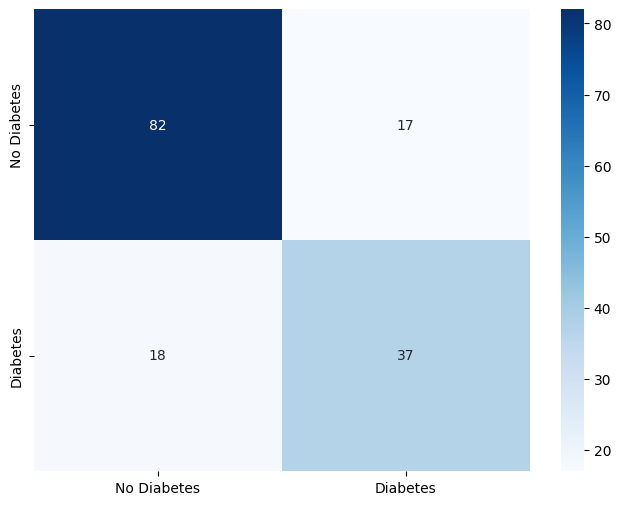

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])

In [14]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.7727


Plotting the loss curve

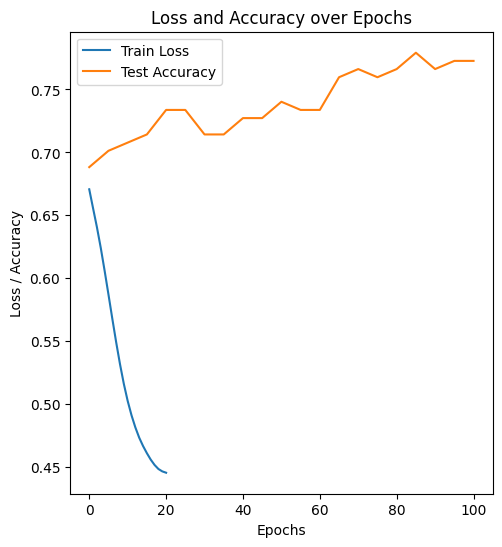

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Train Loss')
plt.plot([i * 5 for i in range(len(accuracy_list))], accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy over Epochs')
plt.legend()
